# Imports

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# Augmented Reality with Planar Homographies

## Load Data


---


*   Loading cover photo
*   Loading AR and book videos




In [6]:
cover = cv2.imread('input/book_cover.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
def load_video(video_path):
    # Create a VideoCapture object and read from input file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if (cap.isOpened() == False):
        print("Error opening video stream or file")

    i = 0
    # Read until video is completed
    while(cap.isOpened()):
        i += 1
        ret, frame = cap.read()
        if ret == True:
            if i == 1:
                frames = frame[np.newaxis, ...]
            else:
                frame = frame[np.newaxis, ...]
                frames = np.vstack([frames, frame])
                frames = np.squeeze(frames)
        else:
            break

    # Release the VideoCapture and close the window
    cap.release()
    return frames

book_video_frames = load_video('input/book.mov')
panda_video_frames = load_video('input/ar_source.mov')

## Getting Correspondences


---



*   The code defines a function get_correspondences that aims to find correspondences between two input images using the Scale-Invariant Feature Transform (SIFT) algorithm.
*   Matches are sorted based on the ratio of distances between the best and second-best matches. The sort_matches function is defined to facilitate this sorting.

*   A ratio test is then applied to retain only the "good" matches. Matches with a distance ratio less than 0.75 are considered good and stored in the good list.





In [7]:
def get_correspondences(img1, img2):
    """
    Finds correspondences between two images using SIFT algorithm.

    Parameters:
        img1 (numpy.ndarray): The first input image.
        img2 (numpy.ndarray): The second input image.

    Returns:
        tuple: A tuple containing keypoints for img1, keypoints for img2, and a list of good matches.
    """

    # Sort matches based on the ratio of distances between the best and second-best matches
    def sort_matches(m):
        return m[0].distance / m[1].distance

    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Sort matches based on the ratio of distances
    matches = tuple(sorted(matches, key=sort_matches))

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
        else:
            break

    return kp1, kp2, good

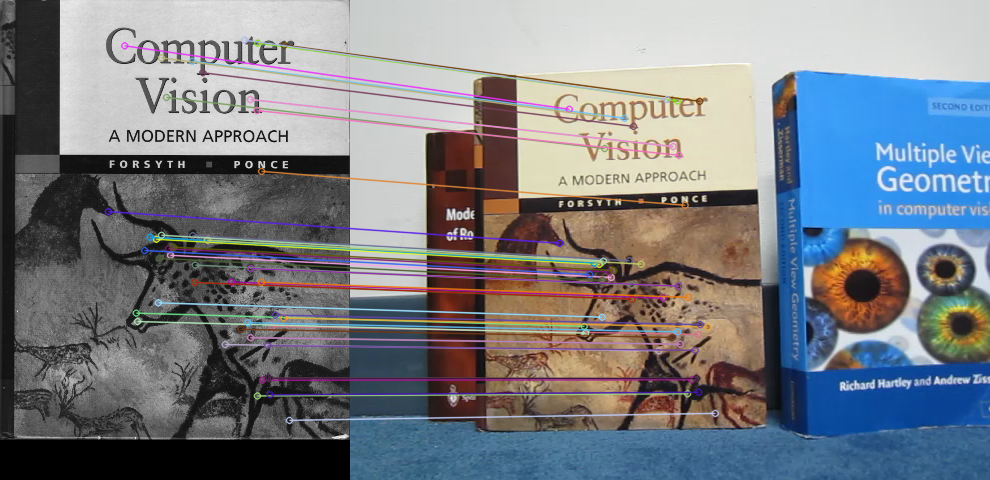

In [8]:
# Plot the 50 best correspondences
kp1, kp2, matches = get_correspondences(cover, book_video_frames[0])
img3 = cv2.drawMatchesKnn(cover, kp1, book_video_frames[0].copy(), kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(img3)

## Compute homography Matrix


---



*   The code defines a function DLT that implements the Direct Linear Transform algorithm for estimating a homography matrix between two sets of corresponding points in the source and destination images.
*   The algorithm constructs a matrix A by iterating over the corresponding points in P and P_dash. For each pair, two rows are created and appended to A to satisfy the homogeneous linear equations.
*   The homography matrix is extracted from the last row of the transposed V matrix. It is then reshaped to a 3x3 matrix and normalized.

In [9]:
def DLT(P, P_dash):
    """
    Computes DLT algorithm for estimating a homography matrix
    between two sets of corresponding points P and P_dash.

    Parameters:
        P (numpy.ndarray): Array of 2D points in the source image.
        P_dash (numpy.ndarray): Array of 2D points in the destination image.

    Returns:
        numpy.ndarray: The estimated homography matrix.
    """

    A = np.empty((0, 9))

    for p,p_d in zip(P, P_dash):
        x, y = p[0], p[1]
        x_d, y_d = p_d[0], p_d[1]

        # Construct 2 rows of matrix A for each correspondence pair
        A_i = np.array([
            [-x, -y, -1, 0, 0, 0, x*x_d, y*x_d, x_d],
            [0, 0, 0, -x, -y, -1, x*y_d, y*y_d, y_d]
        ])

        # Stack the rows to form matrix A
        A = np.vstack((A, A_i))

    u, s, vt = np.linalg.svd(A)

    # Extract the homography matrix from the last row of the transposed V matrix
    homography = vt[-1].reshape((3,3))

    # Normalize the homography matrix
    return homography/homography[2,2]



*   The code defines a function RANSAC that implements the Random Sample Consensus algorithm for robustly estimating a homography matrix between two sets of corresponding points in the source and destination images.

*   The algorithm iterates a specified number of times (num_iterations) to randomly sample 4 point correspondences from the input points P and P_dash.

*   The DLT (Direct Linear Transform) algorithm is then used to estimate a homography matrix (sampled_H) based on the randomly sampled correspondences.

*   The estimated homography matrix is used to project all points in the source image (P) to the destination image. The homogeneous coordinates are normalized, and the inliers are determined by comparing the reprojection error with the specified threshold.

*   The algorithm keeps track of the best model (homography matrix) by selecting the model with the maximum number of inliers.



In [10]:
def RANSAC(P, P_dash, threshold=3.0, num_iterations=100):
    """
    Performs RANSAC  to robustly estimate a homography matrix
    between two sets of corresponding points P and P_dash.

    Parameters:
        P (numpy.ndarray): Array of 2D points in the source image.
        P_dash (numpy.ndarray): Array of 2D points in the destination image.
        threshold (float): Maximum allowable reprojection error for a point to be considered an inlier.
        num_iterations (int): Number of iterations to run RANSAC.

    Returns:
        tuple: A tuple containing the best estimated homography matrix and a boolean mask indicating inliers.
    """

    max_inliers = 0
    best_H = None
    best_inlier_mask = None

    for _ in range(num_iterations):
        # Randomly sample 4 point correspondences
        indices = np.random.choice(len(P), size=4, replace=False)
        sampled_P = P[indices]
        sampled_P_dash = P_dash[indices]

        # Estimate homography using DLT
        sampled_H = DLT(sampled_P, sampled_P_dash)

        # Project points using the estimated homography
        projected_P = np.matmul(sampled_H, np.vstack((P.T, np.ones((1, len(P))))))
        projected_P /= projected_P[2]  # Homogeneous coordinates normalization
        projected_P = projected_P[:2]  # Homogeneous coordinates to heterogeneous coordinates

        # Count inliers using the estimated homography
        inlier_mask = np.zeros(len(P), dtype=bool)
        inliers = 0
        for i in range(len(P)):
            p = P[i]
            p_d = P_dash[i]

            # Check if the reprojection error is below the threshold
            if np.linalg.norm(projected_P[:, i] - p_d) < threshold:
                inliers += 1
                inlier_mask[i] = True

        # Update the best model if the current model has more inliers
        if inliers > max_inliers:
            max_inliers = inliers
            best_H = sampled_H
            best_inlier_mask = inlier_mask

    return best_H, best_inlier_mask

In [11]:
P = np.array([ kp1[m[0].queryIdx].pt for m in matches ]).reshape(-1,2)
P_dash = np.array([ kp2[m[0].trainIdx].pt for m in matches ]).reshape(-1,2)

H, mask = RANSAC(P, P_dash)

# Recompute H using all inliers
H = DLT(P[mask], P_dash[mask])
print("H using our function:")
print(H)

# Check H of built-in function
H_built_in, _ = cv2.findHomography(P, P_dash, cv2.RANSAC)
print("H using built-in function:")
print(H_built_in)

H using our function:
[[ 7.79986874e-01  5.40668072e-03  1.18730046e+02]
 [-4.86094204e-02  7.82987446e-01  7.69910101e+01]
 [-8.12260388e-05 -6.76081510e-05  1.00000000e+00]]
H using built-in function:
[[ 7.80142603e-01  5.67277642e-03  1.18567034e+02]
 [-4.90115324e-02  7.82654591e-01  7.70694317e+01]
 [-8.22704500e-05 -6.80045525e-05  1.00000000e+00]]


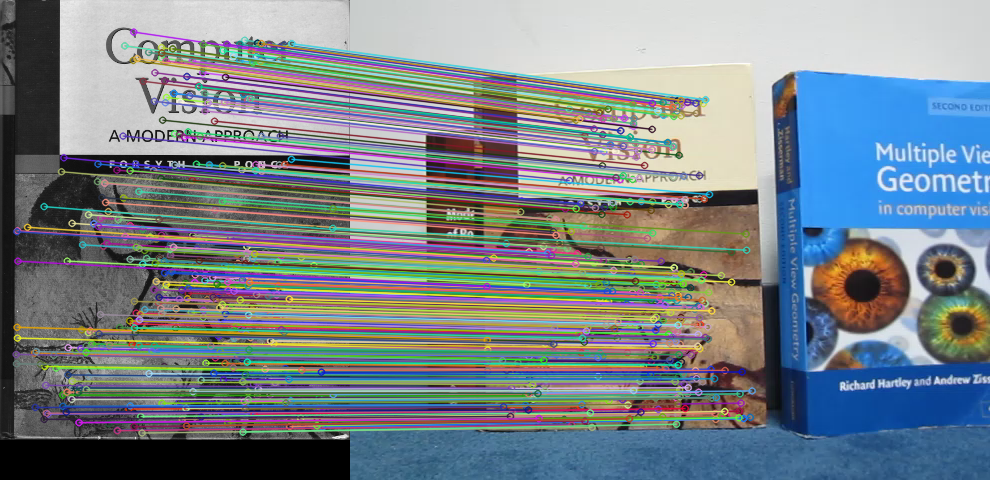

In [12]:
# Draw inliers only
matches = cv2.drawMatchesKnn(cover, kp1, book_video_frames[0].copy(), kp2, matches, None, matchesMask=np.uint8(mask).reshape(-1,1), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(matches)

## Calculate Book Coordinates



*   This code calculates the corners of a rectangle in the source image img1.
*   The corners are defined as the four corners of the book cover image and then apply the Homography matrix (H) on them.




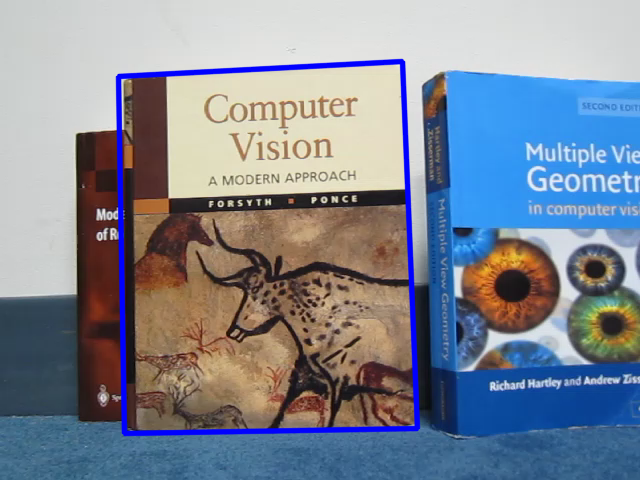

In [13]:
h, w = cover.shape
corners = np.float32([[0, 0],[0, h-1],[w-1, h-1],[w-1, 0]]).reshape(-1,1,2)

# Project corners using the estimated homography matrix
projected_corners = cv2.perspectiveTransform(corners, H)

# Draw the projected rectangle
img3 = cv2.polylines(book_video_frames[0].copy(), [np.int32(projected_corners)], True, 255, 3, cv2.LINE_AA)
cv2_imshow(img3)

## Crop AR Video Frames



*   The function performs cropping by removing a portion of the top and bottom of the image. Specifically, it removes 45 pixels from the top and 45 pixels from the bottom of the image as they were black.
*   The middle third of the width of the image is then selected, effectively cropping the sides of the frame.
*   Adjust aspect ratio to match the cover's one


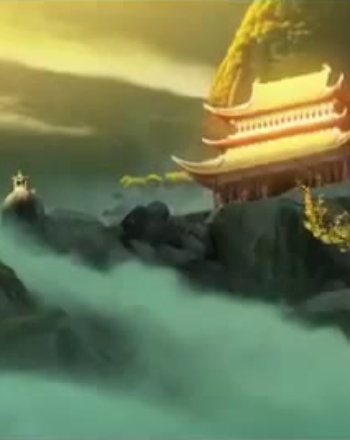

In [14]:
def crop_video(target_dimensions, img):
    """
    Crop and resize a video frame.

    Parameters:
    - target_dimensions: Tuple (width, height) specifying the desired dimensions of the output frame.
    - img: Input video frame to be cropped and resized.

    Returns:
    - Cropped and resized video frame.
    """

    height, width, _ = img.shape

    # Remove top and bottom black pixels and crop the middle third of image
    cropped = img[45:-45, (width // 3): ((width * 2) // 3)]

    adjusted = cv2.resize(cropped, target_dimensions)
    return adjusted

cropped = crop_video((w, h), panda_video_frames[0])
cv2_imshow(cropped)

## Overlay the First Frame of the Two Videos

---


*   The code overlays the warped and cropped image onto the first frame of the book video using the estimated homography matrix H.
*   Anti-aliasing is applied to the borders of the video.

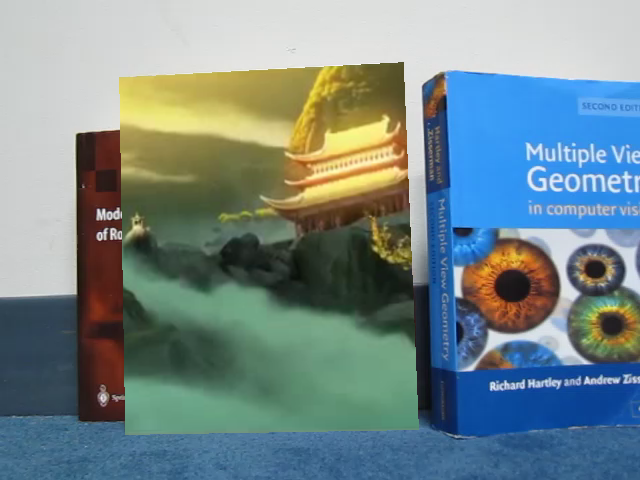

In [15]:
book_video_h, book_video_w, _ = book_video_frames[0].shape

# Warp the cropped image using the estimated homography matrix
overlayed = book_video_frames[0].copy()
overlayed = cv2.warpPerspective(cropped, H, (book_video_w, book_video_h), dst=overlayed, borderMode=cv2.BORDER_TRANSPARENT)

cv2_imshow(overlayed)

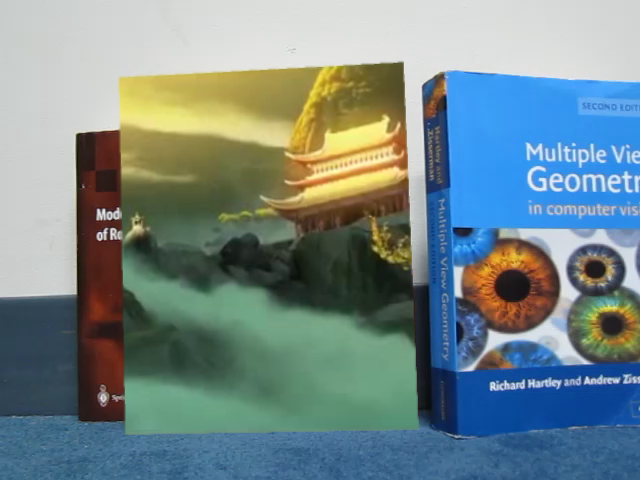

In [16]:
# Anti-aliasing
mask = np.ones(overlayed.shape[:2])*255
mask = cv2.polylines(mask, [np.int32(projected_corners)], True, 0, 2)

result = cv2.GaussianBlur(overlayed, (0,0), sigmaX=1)
result[mask > 0] = overlayed[mask > 0]
cv2_imshow(result)

## Creating AR Application

---



*   Generate an augmented reality (AR) application by overlaying a cropped video onto a book cover.
*   Applying all the previous steps on each frame



In [ ]:
def create_ar_application():
    """
    Create an augmented reality (AR) application by overlaying a cropped video onto a book cover.

    Returns:
    - List of video frames representing the AR application.
    """

    book_h, book_w = cover.shape
    final_video_frames = []

    for i in range(len(panda_video_frames)):
        # Get correspondences between the book cover and panda video frames
        kp1, kp2, matches = get_correspondences(cover.copy(), book_video_frames[i])

        # Extract corresponding points from the matches
        P = np.array([ kp1[m[0].queryIdx].pt for m in matches ]).reshape(-1,2)
        P_dash = np.array([ kp2[m[0].trainIdx].pt for m in matches ]).reshape(-1,2)

        # Apply RANSAC to find a robust homography matrix
        H, mask = RANSAC(P, P_dash)

        # Recompute H using all inliers
        H = DLT(P[mask], P_dash[mask])

        # Define the corners of the book cover in a counter-clockwise order
        corners = np.float32([[0, 0],[0, book_h-1],[book_w-1, book_h-1],[book_w-1, 0]]).reshape(-1,1,2)

        # Project corners using the estimated homography matrix
        projected_corners = cv2.perspectiveTransform(corners, H)
        cropped = crop_video((book_w, book_h), panda_video_frames[i])

        # Crop and warp the panda video frame to match the dimensions of the book cover
        h, w, _ = book_video_frames[i].shape
        overlayed = book_video_frames[i].copy()
        overlayed = cv2.warpPerspective(cropped, H, (w, h), dst=overlayed, borderMode=cv2.BORDER_TRANSPARENT)

        # Anti-aliasing
        mask = np.ones(overlayed.shape[:2])*255
        mask = cv2.polylines(mask, [np.int32(projected_corners)], True, 0, 2)
        result = cv2.GaussianBlur(overlayed, (0,0), sigmaX=1)
        result[mask > 0] = overlayed[mask > 0]

        # Append the frame to the list
        final_video_frames.append(result)

    return final_video_frames

final_video_frames = create_ar_application()

In [ ]:
# Creating AR video using the resulting frames
output_video = cv2.VideoWriter("output/ar.mov", cv2.VideoWriter_fourcc(*"DIVX"), 25, (book_video_frames[0].shape[1], book_video_frames[0].shape[0]))
for i in range(len(final_video_frames)):
    output_video.write(np.array(final_video_frames[i]))
output_video.release()